In [1]:
import tensorflow as tf
import utils as u
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np

from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

%matplotlib inline
import itertools

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
data_folder = '../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])


print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape

(999, 72, 84)
(999, 72, 32)


Shape of regular image is:  (999, 72, 32)
Shape of dead image is:  (999, 72, 32)
Shape of hot image is:  (999, 72, 32)

max of image is:  1819.0



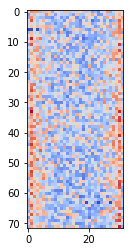

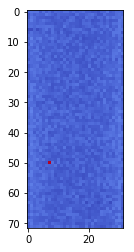

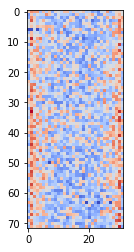

In [3]:
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]
#random_image=[]
count=0
for k in input_images:
    a=np.random.randint(input_images.shape[2]-1)
    b=np.random.randint(input_images.shape[1]-1)
    #a=15
    #b=15
    xdim=(a,a+1)
    ydim=(b,b+1)
   
    hotregion_image.append( u.hotregion(k,xdim,ydim))
    deadregion_image.append(u.killregion(k,xdim,ydim))
    #random_image.append(u.randomregion(k,xdim,ydim))
    #print "xdim,ydim:",xdim,ydim
    #print count
    count+=1
    
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)
#random_image=np.array(random_image)
#print "xdim,ydim",xdim,ydim
print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape
#print "Shape of random image is: " ,random_image.shape

print '\nmax of image is: ' ,np.max(input_images)
print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.show()
plt.clf()


#im=plt.imshow(random_image[1],cmap=cm.coolwarm)
#plt.show()
#plt.clf()
#
im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
plt.show()
plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.

im=plt.imshow(deadregion_image[1],cmap=cm.coolwarm)
plt.show()
plt.clf()
#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))


If you want to see the group of images

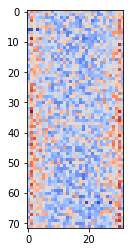

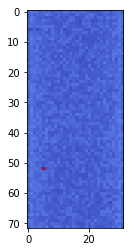

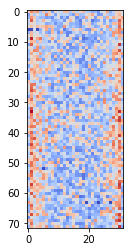

-----------------


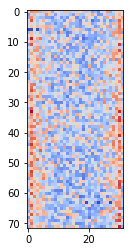

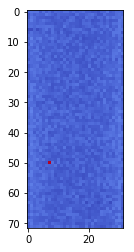

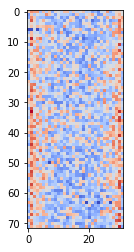

-----------------


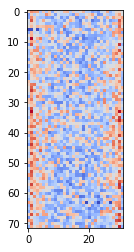

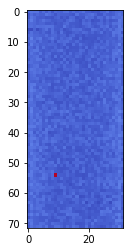

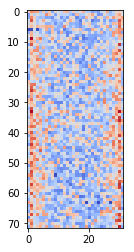

-----------------


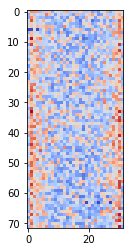

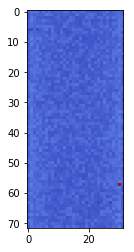

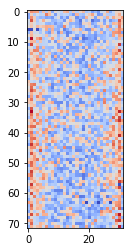

-----------------


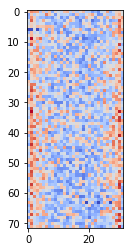

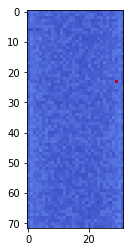

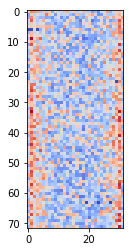

-----------------


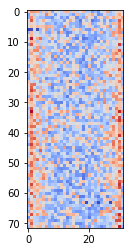

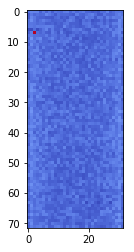

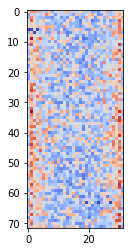

-----------------


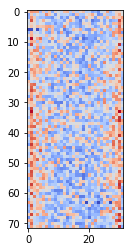

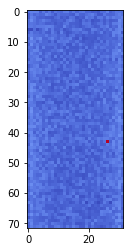

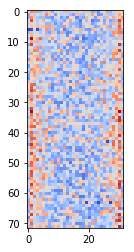

-----------------


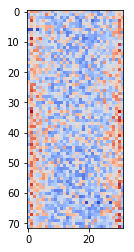

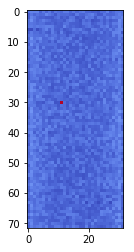

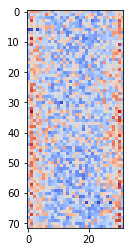

-----------------


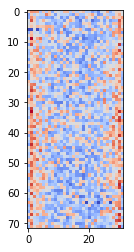

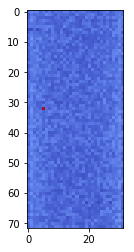

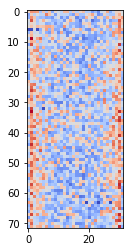

-----------------


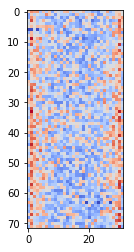

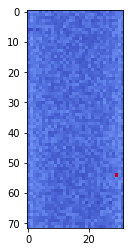

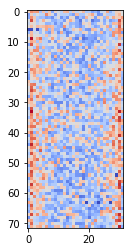

-----------------


In [4]:
for k in range(10):
    im=plt.imshow(input_images[k],cmap=cm.coolwarm)
    plt.show()
    plt.clf()

    #im=plt.imshow(random_image[k],cmap=cm.coolwarm)
    #plt.show()
    #plt.clf()
    #
    im=plt.imshow(hotregion_image[k],cmap=cm.coolwarm)
    plt.show()
    plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
             #as opposed to plt.close which closes the window. If you are showing many images at a time without
             #closing the window it is better.
    
    im=plt.imshow(deadregion_image[k],cmap=cm.coolwarm)
    plt.show()
    plt.clf()
    print '-----------------'


In [5]:
sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
#sample= np.append(sample,random_image,axis=0)            


print sample.shape

(2997, 72, 32)


create the corresponding label matrices

This line of code below was used when the reshping of the images was needed. Now we use a CNN so we don't need to 

For CNN

In [6]:
X=np.copy(sample)

y=np.zeros((sample.shape[0],1))


In [7]:
#this is because I am only going to add the hot and dead region images

for i in range(2,0,-1):
    y[-i*input_images.shape[0]:]=3-i
#if you want it as intergers leave this as it is
#if you would like it as a vector then do this
y=to_categorical(y,3)
#print 'First few labels are \n',y[:5]
#print y.shape
#print 'Labels from 1 class to another are like this\n',y[998:1004]
#print 'Labels from 1 class to another are like this\n',y[1997:2004]


In [8]:
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

X shape is:  (2997, 72, 32)
y shape is:  (2997, 3)


Xtrain.shape (1798, 72, 32)
Xtest.shape (1199, 72, 32)
ytrain.shape (1798, 3)
ytest.shape (1199, 3)
Printing labels and their corresponding images
-------------------
[ 0.  1.  0.]


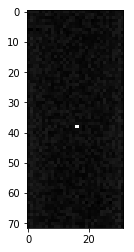

-------------------
[ 0.  1.  0.]


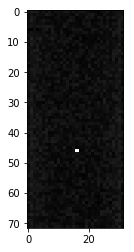

-------------------
[ 1.  0.  0.]


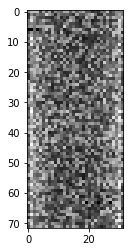

-------------------
[ 0.  1.  0.]


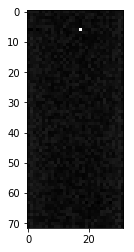

-------------------
[ 1.  0.  0.]


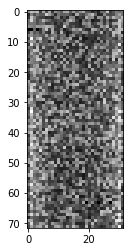

-------------------
[ 1.  0.  0.]


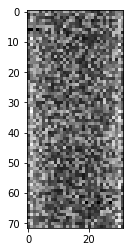

-------------------
[ 1.  0.  0.]


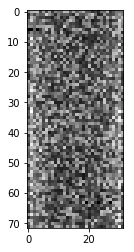

-------------------
[ 0.  0.  1.]


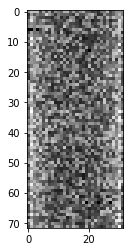

-------------------
[ 0.  1.  0.]


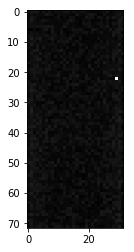

-------------------
[ 0.  1.  0.]


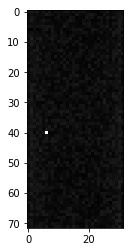

Xtrain.shape after if statement (1798, 72, 32, 1)
Xtest.shape after if statement (1199, 72, 32, 1)
ytrain.shape after if statement (1798, 3)
ytest.shape after if statement (1199, 3)


In [9]:

Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.4,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.gray)
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape
    


# Creating and training the model

In [10]:
# this is the dummy model
model = Sequential([
BatchNormalization(input_shape=input_shape),
Conv2D(8, kernel_size=(3, 3), strides=(2, 2), activation='relu'),
Conv2D(8, kernel_size=(3, 3), strides=(2, 2), activation='relu'),

Dropout(0.25),

Flatten(),

Dense(3, activation='softmax')

])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',#Adam(lr=1e-3),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 72, 32, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 15, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 7, 8)          584       
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 7, 8)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 952)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 2859      
Total params: 3,527
Trainable params: 3,525
Non-trainable params: 2
_________________________________________________________________


In [12]:
checkpointer = ModelCheckpoint(filepath='best_model_with_bad_channels.hdf5', verbose=4, save_best_only=True)
#earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=15 verbose=4, mode='auto')

history = model.fit(Xtrain,ytrain,epochs=250
                    ,verbose=2
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer])#,earlystop])

Train on 1798 samples, validate on 1199 samples
Epoch 1/250
Epoch 00001: val_loss improved from inf to 1.08900, saving model to best_model_with_bad_channels.hdf5
 - 2s - loss: 1.1233 - acc: 0.3370 - val_loss: 1.0890 - val_acc: 0.4604
Epoch 2/250
Epoch 00002: val_loss improved from 1.08900 to 1.05147, saving model to best_model_with_bad_channels.hdf5
 - 1s - loss: 1.0771 - acc: 0.3971 - val_loss: 1.0515 - val_acc: 0.4204
Epoch 3/250
Epoch 00003: val_loss improved from 1.05147 to 0.99984, saving model to best_model_with_bad_channels.hdf5
 - 1s - loss: 1.0257 - acc: 0.4867 - val_loss: 0.9998 - val_acc: 0.4754
Epoch 4/250
Epoch 00004: val_loss improved from 0.99984 to 0.93509, saving model to best_model_with_bad_channels.hdf5
 - 1s - loss: 0.9616 - acc: 0.5428 - val_loss: 0.9351 - val_acc: 0.5246
Epoch 5/250
Epoch 00005: val_loss improved from 0.93509 to 0.88268, saving model to best_model_with_bad_channels.hdf5
 - 1s - loss: 0.8754 - acc: 0.5801 - val_loss: 0.8827 - val_acc: 0.5947
Epoch 

Epoch 52/250
Epoch 00052: val_loss did not improve
 - 1s - loss: 0.4843 - acc: 0.6841 - val_loss: 0.4993 - val_acc: 0.6355
Epoch 53/250
Epoch 00053: val_loss did not improve
 - 1s - loss: 0.4733 - acc: 0.6741 - val_loss: 0.4950 - val_acc: 0.6389
Epoch 54/250
Epoch 00054: val_loss improved from 0.49187 to 0.49098, saving model to best_model_with_bad_channels.hdf5
 - 1s - loss: 0.4768 - acc: 0.6624 - val_loss: 0.4910 - val_acc: 0.6706
Epoch 55/250
Epoch 00055: val_loss did not improve
 - 1s - loss: 0.4698 - acc: 0.6802 - val_loss: 0.4953 - val_acc: 0.6555
Epoch 56/250
Epoch 00056: val_loss improved from 0.49098 to 0.49093, saving model to best_model_with_bad_channels.hdf5
 - 1s - loss: 0.4799 - acc: 0.6702 - val_loss: 0.4909 - val_acc: 0.6239
Epoch 57/250
Epoch 00057: val_loss did not improve
 - 1s - loss: 0.4758 - acc: 0.6908 - val_loss: 0.4914 - val_acc: 0.6439
Epoch 58/250
Epoch 00058: val_loss did not improve
 - 1s - loss: 0.4868 - acc: 0.6841 - val_loss: 0.5008 - val_acc: 0.6422
Epo

Epoch 115/250
Epoch 00115: val_loss did not improve
 - 1s - loss: 0.4668 - acc: 0.7019 - val_loss: 0.4943 - val_acc: 0.6122
Epoch 116/250
Epoch 00116: val_loss did not improve
 - 1s - loss: 0.4554 - acc: 0.7269 - val_loss: 0.5066 - val_acc: 0.6297
Epoch 117/250
Epoch 00117: val_loss did not improve
 - 1s - loss: 0.4495 - acc: 0.7113 - val_loss: 0.4928 - val_acc: 0.6539
Epoch 118/250
Epoch 00118: val_loss did not improve
 - 1s - loss: 0.4491 - acc: 0.7358 - val_loss: 0.4956 - val_acc: 0.6188
Epoch 119/250
Epoch 00119: val_loss did not improve
 - 1s - loss: 0.4659 - acc: 0.7258 - val_loss: 0.4915 - val_acc: 0.6372
Epoch 120/250
Epoch 00120: val_loss did not improve
 - 1s - loss: 0.4499 - acc: 0.7358 - val_loss: 0.4957 - val_acc: 0.6272
Epoch 121/250
Epoch 00121: val_loss did not improve
 - 1s - loss: 0.4492 - acc: 0.7236 - val_loss: 0.5028 - val_acc: 0.6197
Epoch 122/250
Epoch 00122: val_loss did not improve
 - 1s - loss: 0.4423 - acc: 0.7219 - val_loss: 0.4983 - val_acc: 0.6063
Epoch 12

Epoch 00181: val_loss did not improve
 - 1s - loss: 0.4131 - acc: 0.7608 - val_loss: 0.5111 - val_acc: 0.6480
Epoch 182/250
Epoch 00182: val_loss did not improve
 - 1s - loss: 0.4265 - acc: 0.7631 - val_loss: 0.5129 - val_acc: 0.6130
Epoch 183/250
Epoch 00183: val_loss did not improve
 - 1s - loss: 0.4153 - acc: 0.7742 - val_loss: 0.5455 - val_acc: 0.6214
Epoch 184/250
Epoch 00184: val_loss did not improve
 - 1s - loss: 0.4232 - acc: 0.7586 - val_loss: 0.5182 - val_acc: 0.6405
Epoch 185/250
Epoch 00185: val_loss did not improve
 - 1s - loss: 0.4029 - acc: 0.7798 - val_loss: 0.5251 - val_acc: 0.6589
Epoch 186/250
Epoch 00186: val_loss did not improve
 - 1s - loss: 0.4089 - acc: 0.7603 - val_loss: 0.5274 - val_acc: 0.6222
Epoch 187/250
Epoch 00187: val_loss did not improve
 - 1s - loss: 0.4100 - acc: 0.7747 - val_loss: 0.5322 - val_acc: 0.6088
Epoch 188/250
Epoch 00188: val_loss did not improve
 - 1s - loss: 0.4127 - acc: 0.7614 - val_loss: 0.5352 - val_acc: 0.6113
Epoch 189/250
Epoch 00

Epoch 248/250
Epoch 00248: val_loss did not improve
 - 1s - loss: 0.3926 - acc: 0.7914 - val_loss: 0.5480 - val_acc: 0.6480
Epoch 249/250
Epoch 00249: val_loss did not improve
 - 1s - loss: 0.3905 - acc: 0.7981 - val_loss: 0.5457 - val_acc: 0.6255
Epoch 250/250
Epoch 00250: val_loss did not improve
 - 1s - loss: 0.3824 - acc: 0.7870 - val_loss: 0.5509 - val_acc: 0.6372


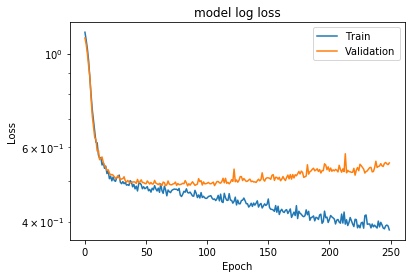

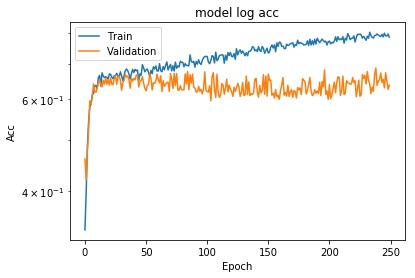

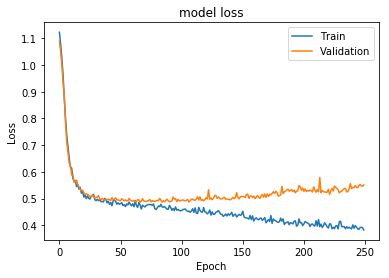

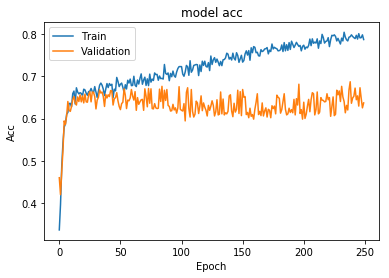

In [13]:
u.plot_loss(history, "model log loss","log")
u.plot_acc(history, "model log acc","log")

u.plot_loss(history, "model loss","linear")
u.plot_acc(history, "model acc","linear")



In [14]:
best_model= load_model('best_model_with_bad_channels.hdf5')

In [15]:
ypred=best_model.predict(Xtest)
ypredproba=best_model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=best_model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

In [16]:
np.all(ypredproba==ypred)
#this confirms my suspicions

True

In [17]:
print ytestclass[40:50],'\n\n\n', ypredclass[40:50]

[[0]
 [1]
 [0]
 [0]
 [2]
 [0]
 [1]
 [1]
 [1]
 [2]] 


[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]]


In [18]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
#print metrics.accuracy_score(ytest,ypred)
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

Confusion matrix, without normalization
[[377   0  26]
 [  0 398   2]
 [360   0  36]]


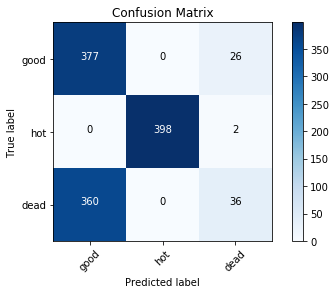

In [19]:
plotlabels=['good','hot','dead']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')

# Now I'm going to recreate this model using the SKlearn API wrapper from Keras

0.727762572166 For the label # 0
0.9975 For the label # 1
0.721421877555 For the label # 2


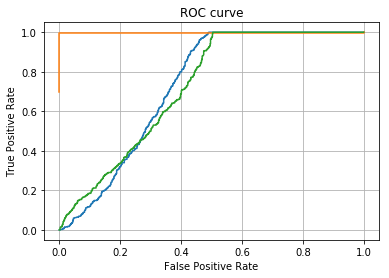

In [26]:
fpr=[]
tpr=[]
thresholds=[]
roc_auc=[]
for i in range(3):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    
    
    roc_auc = auc(fpr, tpr)
    
    print roc_auc,'For the label #',i

    #compute miro average

    plt.plot(fpr,tpr)#, color='green', linestyle='dashed',markerfacecolor='blue',marker='o' )#)markersize=12
    #plt.xlim([-.1,1.5])
    #plt.ylim([-0.1,1.5])    
    plt.title('ROC curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.legend()
    plt.grid(True)
    #print roc_auc     
    #print thresholds